# Lab 4 - Extending Logistic Regression

### Eric Smith and Jake Carlson

## Introduction
For this lab, we will again be examining the Global Terrorism Database maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START) at the University of Maryland. We will be looking at attacks that happened in the United States over the whole time span of the data set, since it's creation in 1974.

We will be extending binary logistic regression based classification to support multiple classes. Specifically, based on the attributes of the input entity, we want to predict what the attack type of the entity is.

## Business Understanding

### Motivations
Protecting the United States from terror threats has been a major objective of the federal government. This is characterized by the founding of the Department of Homeland Security in 2001. But predicting when an attack will happen based on certain attributes is next to impossible. Attempting to train a model on the Global Terrorism Database to learn when terrorist attacks happen will result in a model that is over-trained on the GTD and will fail to predict any such attacks. Not to mention, such a system would have to be accompanied by a large-scale communication monitoring and processing system capable of feeding the model relevant inputs that exemplify a possible attack.

Instead of trying to predict when an attack will happen, our goal is to create a model that can predict the cost associate with an individual attack. Immediately after an attack has happened, law enforcement can feed in information about the attack, such as the attack type, the number of people injured, and the target type, and they could receive an approximation of the amount of property damage dealt to their city. Such a model would allow city officials and law enforcement to estimate in real time how much an attack will cost their city. Knowing the estimated cost would enable city officials to determine if they need to request support from the federal government in a shorter timeframe. Furthermore, cities could plan their future budgets accordingly to incorporate funding in response to a terrorist attack.

Cities have to submit requests to FEMA for non-disaster grants to aid in the prevention and response to terrorist activity. The Department of Homeland Security can also issue grants to aid in the prevention of terrorism. Grant policies start with Congress allocating funds for federal grants of this type. The Executive Branch provides input for how the policy should be implemented. Then grant issuing agencies develop their own policies for how to allocate grant money.

Each state defines their own thresholds for when an attack is severe enough that they will ask for federal assistance. Our model will allow officials to immediately decide if they need to file for a federal grant. Smaller cities have lwoer thresholds and larger cities can handle higher costs before needing assistance.

### Objectives
Based on the characteristics of an attack, such as the target type and the date, we want to assign an estimated cost label to the entity. Because our system will be used to estimate the cost for local city governements, perfect classification of cost is not required. However, it is important that these estimations are accurate because a request for a grant will need to be formed and sent to the federal government.

Based on the distribution of our classes we want to achieve an accuracy that is greater than the ratio of the majority class to the rest of the population. The class counts are given by:

    Catastrophic (class 0): 4
    Major (class 1): 52
    Minor (class 2): 1770
    Unknown (class 3): 190

The majority class is class 2, which constitutes 87% of the data set. We want to achieve a classification accuracy greater than this for our model to be useful.

## Data Preparation

### Attributes
Here is the list of attributes we will keep in our data set to use for classification.

#### General Information
- **iyear** (ordinal): The year the event occured in
- **imonth** (ordinal): The month the event occured in
- **iday** (ordinal): The day the event occured in
- **extended** (binary): 1 if the incident was longer than 24 hours, 0 otherwise
    - **resolution** (ordinal): The date an extended incident was resolved if *extended* is 1


- **inclusion criteria** (binary): There are three inclusion criteria where a 1 indicates the event meets that criteria
    - **crit1**: Political, economic, religious, or social goal
    - **crit2**: Intention to coerce, intimidate, or publicize
    - **crit3**: Outside international humanitarian law


#### Location
We will provide the name of the city to the model. An alternative method would be to train a unique logistic regression algorithm for each city where our system is deployed.
- **city** (text): Name of the city in which the event occured
- **vicinity** (nominal/binary): A 1 indicates the event occured in the immediate vicinity of *city*, 0 indicates the even occured in *city*
- **latitude** (ratio): The latitude of the *city* in which the event occured
- **longitude** (ratio): The longitude of the *city* in which the event occured

#### Attack Type
The most severe method of attack. This will be our class label. Although the original data set contains columns for three different attack types, the attack types are ranked by their severity. Many attacks only have one attack type. By removing the second and third attack types from our data set, we will still be predicting the most severe of the attack types.
- **attacktype1** (ordinal): Most severe attack type

- The attack types follow the following hierarchy:
    1. Assassination
    2. Armed Assault
    3. Bombing/Explosion
    4. Hijacking
    5. Barricade Incident
    6. Kidnapping
    7. Facility/Infrastructure Attack 
    8. Unarmed Assault
    9. Unknown


- **suicide** (nominal/binary): A 1 indicates there was evidence the attacker did not make an effort to escape with their life

#### Target Type
We will only be considering the first target type of the attack. The set of target attributes is provided below:
- **targtype1, targtype1_txt** (nominal): The general type of target from the following list:
    1. Business
    2. Government (General)
    3. Police
    4. Military
    5. Abortion related
    6. Airports and aircraft
    7. Government (Diplomatic)
    8. Educational institution
    9. Food or water supply
    10. Journalists and media
    11. Maritime
    12. NGO
    13. Other
    14. Private citizens and property
    15. Religious figures and institutions
    16. Telecommunication
    17. Terrirists and non-state militias
    18. Tourists
    19. Transportation
    20. Unknown
    21. Utilities
    22. Violent political parties
    

- ? **targsubtype1, targsubtype1_txt** (nominal): There are a number of subtypes for each of the above target types

#### Perpetrator Information
The data set provides information on up to three perpetrators if the attack was conducted by multiple groups. We will only be considering the first group, or the one decided to have the most responsibility for the attack.
- **individual** (binary): A 1 indicates the individuals carrying out the attack are not affiliated with a terror organization
- **nperps** (ratio): Indicates the total number of terrorists participating in the event
- **nperpcap** (ratio): Number of perpatrators taken into custody
- **claimed** (binary): A 1 indicates a person or group claimed responsibility for the attack
- **claimmode** (nominal): Records the method the terror group used to claim responsibility for the attack. Can be one of the ten following categories:
    1. Letter
    2. Call (post-incident)
    3. Call (pre-incident)
    4. E-mail
    5. Note left at scene
    6. Video
    7. Posted to website
    8. Personal claim
    9. Other
    10. Unknown


#### Casualties and Consequences
- **nkill** (ratio): Records the number of confirmed kills for the incident
- **nkillter** (ratio): Indicates the number of terrorists who were killed in the event
- **nwound** (ratio): Indicates the number of people who sustained non-fatal injuries in the event
- **nwoundte** (ratio): Indicates the number of terrorists who sustained non-lethal injuries
- **property** (binary): A 1 indicates the event resulted in property damage. We will only select entities that resulted in property damage
- **propextent** (ordinal): If *property* is a 1, this field records the extent of the property damage following the scheme:
    <ol start='0'>
        <li>Catastrophic (likely > \$1 billion)</li>
        <li>Major (likely > \$1 million and < \$1 billion)</li>
        <li>Minor (likely < \$1 million)</li>
        <li>Unknown</li>
    </ol>

### Data Cleaning
We will clean the data set so only the above attributes are present.

In [1]:
import pandas as pd

df = pd.read_csv('../Lab1/data/us_only.csv', encoding='ISO-8859-1')
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
1,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,...,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN
2,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,The New Years Gang issue a communiqu to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN
3,197001030001,1970,1,3,NaN,0,NaN,217,United States,1,...,"Karl Armstrong's girlfriend, Lynn Schultz, dro...",Committee on Government Operations United Stat...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0,0,0,0,NaN
4,197001050001,1970,1,1,NaN,0,NaN,217,United States,1,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN


In [2]:
df.columns.values

array(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region', 'region_txt',
       'provstate', 'city', 'latitude', 'longitude', 'specificity',
       'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'alternative', 'alternative_txt', 'multiple',
       'success', 'suicide', 'attacktype1', 'attacktype1_txt',
       'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2',
       'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2',
       'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt',
       'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3',
       'natlty3_txt', 'gname', 'gsubname', 'gname2', 'gsubname2', 'gname3',
       'gsubname3', 'motive', 'guncertain1', 'guncertain2', 'guncertain3',
       'in

In [3]:
# drop rows without property damage or unknown city
orig_len = df.shape[0]
df = df[df['property'] == 1]
df = df[df['city'] != "Unknown"]
new_len = df.shape[0]
print("Percent maintained: ", new_len/orig_len*100, "%")

# select columns of interest
df = df[['iyear', 'imonth', 'iday', 'extended', 'vicinity',
         'latitude', 'longitude', 'crit1', 'crit2', 'crit3', 'suicide',
         'attacktype1', 'targtype1', 'individual', 'nperps', 'nperpcap', 
         'claimed', 'claimmode', 'nkill', 'nkillter', 'nwound', 
         'nwoundte', 'propextent']]

Percent maintained:  73.09644670050761 %


In [4]:
df.head()

,iyear,imonth,iday,extended,vicinity,latitude,longitude,crit1,crit2,crit3,...,individual,nperps,nperpcap,claimed,claimmode,nkill,nkillter,nwound,nwoundte,propextent
0,1970,1,1,0,0,37.005105,-89.176269,1,1,1,...,0,-99.0,-99.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0
1,1970,1,2,0,0,37.805065,-122.273024,1,1,1,...,0,-99.0,-99.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0
2,1970,1,2,0,0,43.076592,-89.412488,1,1,1,...,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
3,1970,1,3,0,0,43.072950,-89.386694,1,1,1,...,0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0
5,1970,1,6,0,0,39.740010,-104.992259,1,1,1,...,0,-99.0,-99.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 0 to 2756
Data columns (total 23 columns):
iyear          2016 non-null int64
imonth         2016 non-null int64
iday           2016 non-null int64
extended       2016 non-null int64
vicinity       2016 non-null int64
latitude       2016 non-null float64
longitude      2016 non-null float64
crit1          2016 non-null int64
crit2          2016 non-null int64
crit3          2016 non-null int64
suicide        2016 non-null int64
attacktype1    2016 non-null int64
targtype1      2016 non-null int64
individual     2016 non-null int64
nperps         1191 non-null float64
nperpcap       1153 non-null float64
claimed        1155 non-null float64
claimmode      339 non-null float64
nkill          1952 non-null float64
nkillter       1175 non-null float64
nwound         1936 non-null float64
nwoundte       1165 non-null float64
propextent     1484 non-null float64
dtypes: float64(11), int64(12)
memory usage: 378.0 KB


In [6]:
import numpy as np
from sklearn import preprocessing
from datetime import datetime

logical_cols = ['extended', 'vicinity', 'crit1', 'crit2', 'crit3',
                'suicide', 'individual', 'claimed']
categorical_cols = ['attacktype1', 'targtype1', 'claimmode']
ratio_cols = ['latitude', 'longitude', 'nperps', 'nperpcap', 'nkill',
              'nkillter', 'nwound', 'nwoundte']

# replace unknowns with nan
logical_replace = dict((l, {-9:np.nan}) for l in ['claimed'])
ratio_replace = dict((r, {-99:np.nan, -9:np.nan}) for r in ratio_cols)
df.replace(to_replace=logical_replace, inplace=True)
df.replace(to_replace=ratio_replace, inplace=True)

# might want to remove outliers here

# replace NA's with median for col
df.fillna(value=df.median(), inplace=True)

# convert logical cols to bools
for l in logical_cols:
    df[l] = df[l].astype('bool')

# normalize ratio cols
min_max_scaler = preprocessing.MinMaxScaler()
df[ratio_cols] = min_max_scaler.fit_transform(df[ratio_cols])

# standardize date attributes
# use year, month, and day to get day number in year
day_list = []
for r in df[['iyear', 'imonth', 'iday']].iterrows():
    # fudge day 0 to 1
    if r[1].iday == 0:
        day_list.append(
            datetime(r[1].iyear, r[1].imonth, 1).timetuple().tm_yday)
    else:
        day_list.append(
            datetime(r[1].iyear, r[1].imonth, r[1].iday).timetuple().tm_yday)
        
df = df.assign(dayn=day_list)

# drop month and day attributes
df.drop(['imonth', 'iday'], axis=1, inplace=True)

# normalize day number and year col
df['iyear'] = df['iyear'].astype(np.float64)
df['dayn'] = df['dayn'].astype(np.float64)
df[['iyear', 'dayn']] = min_max_scaler.fit_transform(df[['iyear', 'dayn']])

# convert categorical cols as ints
for c in categorical_cols:
    df[c] = df[c].astype(np.int64)

# one-hot encode categorical cols
df = pd.get_dummies(df, prefix=categorical_cols, columns=categorical_cols)

# zero-index propextent
df.propextent = df.propextent - 1

df.head()

,iyear,extended,vicinity,latitude,longitude,crit1,crit2,crit3,suicide,individual,...,claimmode_1,claimmode_2,claimmode_3,claimmode_4,claimmode_5,claimmode_6,claimmode_7,claimmode_8,claimmode_9,claimmode_10
0,0.0,False,False,0.406195,0.261021,True,True,True,False,False,...,0,0,0,0,1,0,0,0,0,0
1,0.0,False,False,0.423262,0.135239,True,True,True,False,False,...,0,0,0,0,1,0,0,0,0,0
2,0.0,False,False,0.535729,0.260123,True,True,True,False,False,...,1,0,0,0,0,0,0,0,0,0
3,0.0,False,False,0.535651,0.260221,True,True,True,False,False,...,0,0,0,0,1,0,0,0,0,0
5,0.0,False,False,0.464543,0.200913,True,True,True,False,False,...,0,0,0,0,1,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 0 to 2756
Data columns (total 60 columns):
iyear            2016 non-null float64
extended         2016 non-null bool
vicinity         2016 non-null bool
latitude         2016 non-null float64
longitude        2016 non-null float64
crit1            2016 non-null bool
crit2            2016 non-null bool
crit3            2016 non-null bool
suicide          2016 non-null bool
individual       2016 non-null bool
nperps           2016 non-null float64
nperpcap         2016 non-null float64
claimed          2016 non-null bool
nkill            2016 non-null float64
nkillter         2016 non-null float64
nwound           2016 non-null float64
nwoundte         2016 non-null float64
propextent       2016 non-null float64
dayn             2016 non-null float64
attacktype1_1    2016 non-null uint8
attacktype1_2    2016 non-null uint8
attacktype1_3    2016 non-null uint8
attacktype1_4    2016 non-null uint8
attacktype1_5    2016 non-nu

We have done a number of things to prepare our data for modeling. First, we replaced unknown values in each column with the median for that column. Second, we converted attributes that encode a logical value to a boolean. Third, we normalized the ratio attributes so they are all in the range 0 to 1. Fourth, we convert the year, month, and day attribute to a single numeric attribute which represents the day number in the year that the attack occured on. Then we drop the month and day columns. We still want the year attribute because of the change in attack frequency we noticed in Lab 1, so we standardize the year and day number columns. Finally, we one-hot encode all of the categorical attributes in our data set, creating a variety of additional columns that are needed to represent our data in this way.

Next, we will split our data set into training and test sets and save our data to a persistant files for easy loading. We will use stratified suffle split because of the class imbalance. We want to make sure out training and test sets are representative of our population.

In [8]:
# save full clean data set
df.to_csv('./clean-data/us-clean.csv', sep=',')

In [9]:
# generate train and test sets
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn import svm

labels = df['propextent']
df_attr = df.drop(['propextent'], axis=1)

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=64)
for train_idx, test_idx in sss.split(df_attr.values, labels.values):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(df_attr.values[train_idx]), pd.DataFrame(df_attr.values[test_idx])
    y_train, y_test = pd.DataFrame(labels.values[train_idx]), pd.DataFrame(labels.values[test_idx])

X_train.to_csv('./clean-data/train-data.csv', sep=',')
X_test.to_csv('./clean-data/test-data.csv', sep=',')
y_train.to_csv('./clean-data/train-labels.csv', sep=',')
y_test.to_csv('./clean-data/test-labels.csv', sep=',')

# need to cross validate to determine if 80-20 split is good for our
# data set ...
clf = svm.SVC(kernel='linear', C=1)
scores = clf.fit(X_train, y_train.values.ravel()).score(X_train, y_train)
print(scores)

clf = svm.SVC(kernel='linear', C=1)
scores = clf.fit(X_test, y_test.values.ravel()).score(X_test, y_test)
print(scores)

0.879652605459
0.881188118812


Accuracy is higher for the test set, so an 80/20 split is a good choice for our set.

## Modeling
We will adapt the one-versus-all logistic regression classifier implemented in class to be more similar to the scikit-learn implementation. We will add stochastic gradient descent and Newton's method to the logistic regression classifier and allow the user to select the method they want to use. We will also implement L1 and L2 regularization terms that the user can choose to prevent overfitting on the training data.

While we develop our implementation, we will use the full data set for training and prediction.

First we will load data from disk.

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('./clean-data/us-clean.csv', index_col=0)

# convert one-hot encoded rows to uint8
cols = list(df.columns.values)[19:60]
df[cols] = df[cols].astype(np.uint8)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 0 to 2756
Data columns (total 60 columns):
iyear            2016 non-null float64
extended         2016 non-null bool
vicinity         2016 non-null bool
latitude         2016 non-null float64
longitude        2016 non-null float64
crit1            2016 non-null bool
crit2            2016 non-null bool
crit3            2016 non-null bool
suicide          2016 non-null bool
individual       2016 non-null bool
nperps           2016 non-null float64
nperpcap         2016 non-null float64
claimed          2016 non-null bool
nkill            2016 non-null float64
nkillter         2016 non-null float64
nwound           2016 non-null float64
nwoundte         2016 non-null float64
propextent       2016 non-null float64
dayn             2016 non-null float64
attacktype1_1    2016 non-null uint8
attacktype1_2    2016 non-null uint8
attacktype1_3    2016 non-null uint8
attacktype1_4    2016 non-null uint8
attacktype1_5    2016 non-nu

In [11]:
from scipy.special import expit

class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)

class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

The implementation up till here has been the inclass implementation. We will check that we can make predictions using this classifier before extending the functionality.

In [12]:
X = df.drop('propextent', axis=1).astype(np.float).as_matrix()
y = df.as_matrix(columns=['propextent']).astype(np.int).flatten()

print(set(y))

{0, 1, 2, 3}


In [13]:
from sklearn.metrics import accuracy_score
params = dict(eta=1,
              iterations=1500)
lr = LogisticRegression(**params)

lr.fit(X, y)
yhat = lr.predict(X)

print("Unique values predicted: " , set(yhat))
print('Accuracy of: ', accuracy_score(y,yhat))


Unique values predicted:  {0, 1, 2}
Accuracy of:  0.880456349206


In [14]:
print("Catastrophic (class 0): {}".format(
    len(df[df.propextent == 0].propextent.tolist())))
print("Major (class 1): {}".format(
    len(df[df.propextent == 1].propextent.tolist())))
print("Minor (class 2): {}".format(
    len(df[df.propextent == 2].propextent.tolist())))
print("Unknown (class 3): {}".format(
    len(df[df.propextent == 3].propextent.tolist())))

Catastrophic (class 0): 4
Major (class 1): 52
Minor (class 2): 1770
Unknown (class 3): 190


We are able to accuratly make predictions using this classifier. However, we have a large class imbalance. Events that resulted in minor property damage far out number the remaining classes. In order to account for this, we will implement a weighted binary logistic regression classifier that considers the frequency of the classes when adding the bias term to the data. Classes with greater frequency will have lower bias and minority classes will have greater bias.

In [15]:
class WeightedVectorBinaryLogisticRegression(VectorBinaryLogisticRegression):
    def __init__(self, eta, iterations=20, C=0.001, norm='L1'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.norm = norm
    
    def _add_freq_bias(self,X,y):
        self.freq_ = np.array(([1/list(y).count(y[i]) for i in range(len(y))])).reshape(len(y),1)
        return np.hstack((self.freq_, X))
    
    def fit(self, X, y):
        Xb = self._add_freq_bias(X,y) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient = self._apply_regularization(gradient)
        
        return gradient

    def _apply_regularization(self, gradient):
        if self.norm == 'L1':
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.norm == 'L2':
            gradient[1:] += -2 * self.w_[1:] ** 2 * self.C
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
            
class WeightedLogisticRegression(LogisticRegression):
    def __init__(self, eta, iterations=20, C=0.001, norm=None):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.norm = norm
    
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = WeightedVectorBinaryLogisticRegression(self.eta,self.iters,self.C)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

In [16]:
params = dict(eta=1,
              iterations=20,
              C=0.53)
wlr = WeightedLogisticRegression(**params)
wlr.fit(X, y)
yhat = wlr.predict(X)

print("Unique values predicted: " , set(yhat))
print('Accuracy of: ', accuracy_score(y,yhat))

Unique values predicted:  {2, 3}
Accuracy of:  0.833333333333


In [17]:
params = dict(eta=1,
              iterations=20,
              C=0.5)
wlr = WeightedLogisticRegression(**params)
wlr.fit(X, y)
yhat = wlr.predict(X)

print("Unique values predicted: " , set(yhat))
print('Accuracy of: ', accuracy_score(y,yhat))

Unique values predicted:  {2}
Accuracy of:  0.877976190476


This classifer performs comparably to the inclass implementation. However, all of our accuracy is coming from predicting the majority class only. We have tried a variety of input combinations and regulatization routines, but have been unable to overcome the class imbalance. Even if we predict multiple classes, our accuracy begins to drop off because we are misclassifying other property damage extents.

We want to add a few more optimization methods. We will extend the weighted binary logistic regression class and update the gradient method to implement stochastic gradient descent and the hessian method.

In [18]:
class StochasticLogisticRegression(WeightedVectorBinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient = self._apply_regularization(gradient)
        
        return gradient

In [19]:
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(WeightedVectorBinaryLogisticRegression):    
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian
        
        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient = self._apply_regularization(gradient)

        return pinv(hessian) @ gradient

We create a final classifier class that allows the user to choose the optimization method and the regulatization routine.

In [20]:
class LogisticRegressionClassifier(WeightedLogisticRegression):
    def __init__(self, classifier_type=0, eta=0.1, iterations=10, C=0.01, norm='L1'):
        self.classifier = {'steepest': WeightedVectorBinaryLogisticRegression, 
                           'stochastic': StochasticLogisticRegression, 
                           'newton': HessianBinaryLogisticRegression}[classifier_type]
        self.params = dict(eta=eta, iterations=iterations, C=C, norm=norm)

    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = self.classifier(**self.params)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

In [21]:
# no regularization
params = dict(classifier_type='steepest',
              eta=0.1,
              iterations=500,
              C=0.00001,
              norm=None)

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Weighted Vector: ',accuracy_score(y,yhat))

params = dict(classifier_type='stochastic',
              eta=0.1,
              iterations=500,
              C=0.00001,
              norm=None)

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Stochastic: ',accuracy_score(y,yhat))

params = dict(classifier_type='newton',
              eta=0.1,
              iterations=50,
              C=0.001,
              norm=None)

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Hessian: ',accuracy_score(y,yhat))

# L1 norm
params = dict(classifier_type='steepest',
              eta=0.1,
              iterations=500,
              C=0.00001)

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Weighted Vector w/ L1: ',accuracy_score(y,yhat))

params = dict(classifier_type='stochastic',
              eta=0.1,
              iterations=500,
              C=0.00001)

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Stochastic w/ L1: ',accuracy_score(y,yhat))

params = dict(classifier_type='newton',
              eta=0.1,
              iterations=50,
              C=0.001)

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Hessian w/ L1: ',accuracy_score(y,yhat))

# L2 norm
params = dict(classifier_type='steepest',
              eta=0.1,
              iterations=500,
              C=0.00001,
              norm='L2')

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Weighted Vector w/ L2: ',accuracy_score(y,yhat))

params = dict(classifier_type='stochastic',
              eta=0.1,
              iterations=500,
              C=0.00001,
              norm='L2')

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Stochastic w/ L2: ',accuracy_score(y,yhat))

params = dict(classifier_type='newton',
              eta=0.1,
              iterations=10,
              C=0.001,
              norm='L2')

lrc = LogisticRegressionClassifier(**params)
lrc.fit(X, y)
yhat = lrc.predict(X)

print('Accuracy of Hessian w/ L2: ',accuracy_score(y,yhat))

Accuracy of Weighted Vector:  0.877976190476
Accuracy of Stochastic:  0.877976190476
Accuracy of Hessian:  0.0257936507937
Accuracy of Weighted Vector w/ L1:  0.877976190476
Accuracy of Stochastic w/ L1:  0.877976190476
Accuracy of Hessian w/ L1:  0.0282738095238
Accuracy of Weighted Vector w/ L2:  0.877976190476
Accuracy of Stochastic w/ L2:  0.877976190476
Accuracy of Hessian w/ L2:  0.0257936507937


### Generalization Performance
We will now use a range of parameters for each clafficication method to see how the accuracy changes with respect to the input parameters. We will now use the distict training and testing data sets that we generated in Data Preparation.

Read test and train data from disk.

In [22]:
X_train = pd.read_csv('./clean-data/train-data.csv', index_col=0)
X_test = pd.read_csv('./clean-data/test-data.csv', index_col=0)
y_train = pd.read_csv('./clean-data/train-labels.csv', index_col=0)
y_test = pd.read_csv('./clean-data/test-labels.csv', index_col=0)

X_train = X_train.astype(np.float).as_matrix()
X_test = X_test.astype(np.float).as_matrix()
y_train = y_train.as_matrix().astype(np.int).flatten()
y_test = y_test.as_matrix().astype(np.int).flatten()

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1612, 59)
(1612,)
(404, 59)
(404,)


In [24]:
n_iterations = [10, 250, 500, 750, 1000, 1250, 1500]
Cs = [0.0001, 0.01, 0.1, 0.5, 0.8, 1]
types = ['steepest', 'stochastic', 'newton']
print((len(n_iterations), len(Cs), len(types)))

(7, 6, 3)


In [26]:
accuracies = np.zeros((len(n_iterations), len(Cs), len(types)))

for n in range(len(n_iterations)):
    for c in range(len(Cs)):
        for t in range(len(types)):
            params = dict(classifier_type=types[t],
                          eta=0.1,
                          iterations=n_iterations[n],
                          C=Cs[c],
                          norm=None)
            lrc = LogisticRegressionClassifier(**params)
            lrc.fit(X_train, y_train)
            yhat = lrc.predict(X_test)
            accuracies[n][c][t] = accuracy_score(y_test, yhat)
        

In [27]:
import json
with open('./clean-data/accuracies.json', 'w') as f: f.write(json.dumps(accuracies, default=lambda x: list(x), indent=4))
accuracies

array([[[ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248]],

       [[ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772]],

       [[ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772]],

       [[ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87

In [25]:
import json

with open('./clean-data/accuracies.json') as data_file:    
    j = json.load(data_file)

accuracies = np.array(j)
accuracies

array([[[ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248],
        [ 0.87871287,  0.87871287,  0.02475248]],

       [[ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772]],

       [[ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772]],

       [[ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87871287,  0.87871287,  0.02722772],
        [ 0.87

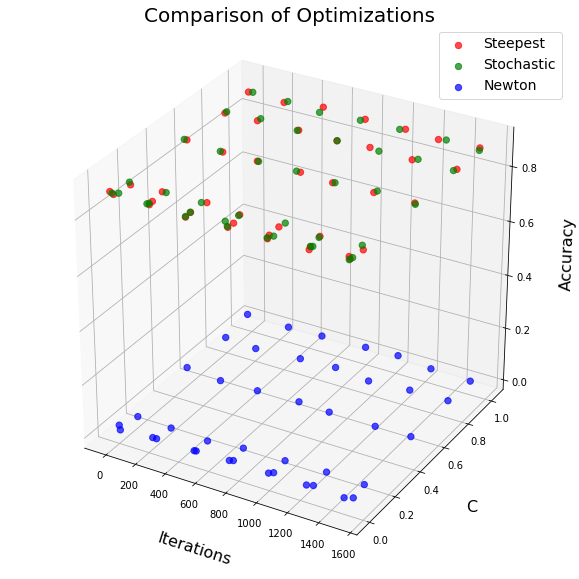

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

'''
X = n_iterations
Y = Cs
Z = accuracy

red = steepest
green = stochastic
blue = newton
'''

# add some jitter for overlapping points: https://stackoverflow.com/a/21276920
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

types = ['Steepest', 'Stochastic', 'Newton']
colors = ['red', 'green', 'blue']
scatter_dict = {0: {'x': [], 'y': [], 'z': []},
                1: {'x': [], 'y': [], 'z': []},
                2: {'x': [], 'y': [], 'z': []}}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for n in range(len(n_iterations)):
    for c in range(len(Cs)):
        for t in range(len(types)):
            scatter_dict[t]['x'].append(n_iterations[n])
            scatter_dict[t]['y'].append(Cs[c])
            scatter_dict[t]['z'].append(accuracies[n][c][t])

for i in range(len(colors)):
    ax.scatter(rand_jitter(scatter_dict[i]['x']),
               rand_jitter(scatter_dict[i]['y']),
               rand_jitter(scatter_dict[i]['z']),
               c=colors[i], marker='o', label=types[i], s=40, alpha=0.7)

plt.title("Comparison of Optimizations", fontsize=20, y=1.08)
ax.set_xlabel('Iterations', fontsize=16, labelpad=20)
ax.set_ylabel('C', fontsize=16, labelpad=20)
ax.set_zlabel('Accuracy', fontsize=16, labelpad=20)
ax.legend(loc="upper right", fontsize=14)
plt.show()

We see that stochastic gradient descent and steepest descent have the highest accuracies overall. Newton's method does not perform well for the input parameters we have chosen. Interestingly, once we reach a over 1000 iterations, the accuracy of stochastic and steepest drops off to meet Newton.

### Comparing to Scikit-learn
We will now compare our custom logistic regression classifier to the scikit-learn implementation. We will use the same number of iterations, the same normalization, and the same cost value. This will offer a fair comparison between the two values.

In [28]:
import time
from sklearn.linear_model import LogisticRegression as lr

sk_train_start_t = time.clock()
sk_lr = lr(penalty='l1', solver="saga", max_iter=10, C=0.01).fit(X_train, y_train)
sk_train_end_t = time.clock()
yhat_sk = sk_lr.predict(X_test)
sk_pred_end_t = time.clock()

params = dict(classifier_type='steepest',
              eta=0.1,
              iterations=10,
              C=0.01,
              norm='L1')

custom_train_start_t = time.clock()
custom_lr = LogisticRegressionClassifier(**params)
custom_lr.fit(X_train, y_train)
custom_train_end_t = time.clock()
yhat_custom = custom_lr.predict(X_test)
custom_pred_end_t = time.clock()

params = dict(eta=0.1,iterations=10)

class_train_start_t = time.clock()
class_lr = LogisticRegression(**params)
class_lr.fit(X_train, y_train)
class_train_end_t = time.clock()
yhat_class = class_lr.predict(X_test)
class_pred_end_t = time.clock()

sk_acc = accuracy_score(y_test, yhat_sk)
sk_train = (sk_train_end_t - sk_train_start_t)*1000
sk_predict = (sk_pred_end_t - sk_train_end_t)*1000

custom_acc = accuracy_score(y_test, yhat_custom)
custom_train = (custom_train_end_t - custom_train_start_t)*1000
custom_predict = (custom_pred_end_t - custom_train_end_t)*1000

class_acc = accuracy_score(y_test, yhat_class)
class_train = (class_train_end_t - class_train_start_t)*1000
class_predict = (class_pred_end_t - class_train_end_t)*1000

print("Sklearn accuracy: {}".format(sk_acc))
print("Sklearn train time: {} ms".format(sk_train))
print("Sklearn predict time: {} ms".format(sk_predict))
print("Custom implementation accuracy: {}".format(custom_acc))
print("Custom train time: {} ms".format(custom_train))
print("Custom predict time: {} ms".format(custom_predict))
print("In-class implementation accuracy: {}".format(class_acc))
print("In-class train time: {} ms".format(class_train))
print("In-class predict time: {} ms".format(class_predict))

Sklearn accuracy: 0.8787128712871287
Sklearn train time: 13.030999999998016 ms
Sklearn predict time: 0.8539999999968018 ms
Custom implementation accuracy: 0.8787128712871287
Custom train time: 2515.2360000000017 ms
Custom predict time: 0.40899999999766123 ms
In-class implementation accuracy: 0.8787128712871287
In-class train time: 13.914999999997235 ms
In-class predict time: 0.5250000000032173 ms


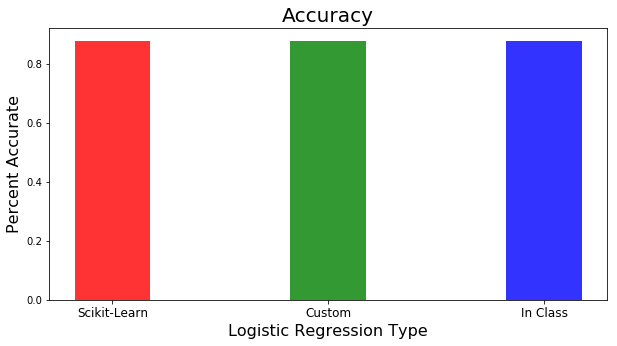

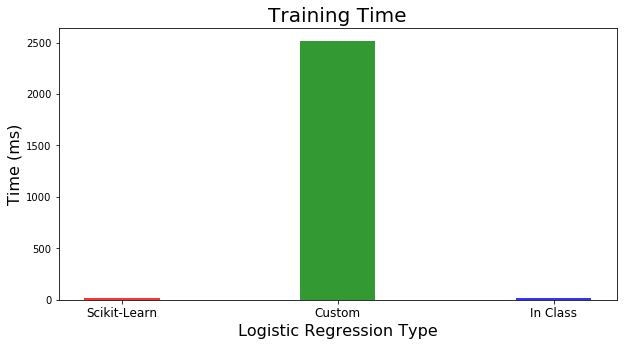

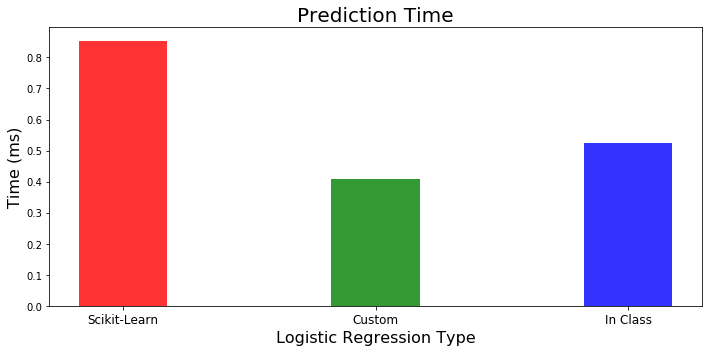

In [101]:
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 3
sk = (sk_acc, sk_train, sk_predict)
custom = (custom_acc, custom_train, custom_predict)
in_class = (class_acc, class_train, class_predict)

accuracy = (sk_acc, custom_acc, class_acc)
training = (sk_train, custom_train, class_train)
predict = (sk_predict, custom_predict, class_predict)

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, accuracy, bar_width,
                 alpha=opacity,
                 color=['r', 'g', 'b'])
plt.xlabel('Logistic Regression Type', fontsize=16)
plt.ylabel('Percent Accurate', fontsize=16)
plt.title('Accuracy', fontsize=20)
plt.xticks(np.arange(3), ('Scikit-Learn', 'Custom', 'In Class'), fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
rects2 = plt.bar(index, training, bar_width,
                 alpha=opacity,
                 color=['r', 'g', 'b'])
plt.xlabel('Logistic Regression Type', fontsize=16)
plt.ylabel('Time (ms)', fontsize=16)
plt.title('Training Time', fontsize=20)
plt.xticks(np.arange(3), ('Scikit-Learn', 'Custom', 'In Class'), fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
rects3 = plt.bar(index, predict, bar_width,
                 alpha=opacity,
                 color=['r', 'g', 'b'])
plt.xlabel('Logistic Regression Type', fontsize=16)
plt.ylabel('Time (ms)', fontsize=16)
plt.title('Prediction Time', fontsize=20)
plt.xticks(np.arange(3), ('Scikit-Learn', 'Custom', 'In Class'), fontsize=12)
 
plt.tight_layout()
plt.show()

We see that our model is able to produce the same prediction accuracy on the training set as scikit-learn. A major benefit of the scikit-learn implementation is the dramatically reduced training time. They are able to fit their model to our data in two orders of magnitude less time than our model. However, our model is able to make predictions slightly faster than scikit-learn. Because all of the training would be done before deployment, we would prefer to deploy our model because of the faster prediction times.

## Deployment




## References
Federal Grant Policy:
<a href="https://www.grants.gov/web/grants/learn-grants/grant-policies.html">A Short History of the Federal Grant Policy</a>